### This notebook sets up and runs an FCS diffusion simulation
Click here to open in google colab: http://colab.research.google.com/github/jayunruh/pysimfcs/blob/main/sim_fcs.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
import os
if(not os.path.exists('pysimfcs_utils.py')):
    print('downloading pysimfcs libraries')
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/pysimfcs_utils.py
if(not os.path.exists('analysis_utils.py')):
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/analysis_utils.py
else:
    print('libraries already downloaded')

libraries already downloaded


In [2]:
import numpy as np #this is for doing statistical measurements on arrays
import matplotlib.pyplot as plt #this is for plotting
import pysimfcs_utils as simutils #this has the simulation codes
import analysis_utils as autils #this calculates the correlation
import pandas as pd #this handles data tables

In [3]:
#each diffusing species is described by number of particles, diffusion coefficient, 
#and a brightness array (for each channel)
#simspecies=[{'N':200,'D':10.0,'B':[100000.0]}]
simspecies=[{'N':200,'D':10.0,'B':[20000.0,20000.0]},
           {'N':200,'D':10.0,'B':[20000.0,0.0]}]

In [4]:
#the simulation settings are boxsize (microns), boxpixels, w0 (2 sigma psf)
#zratio (z0/w0), nframes, frametime (us), background (array of cps), dims (active dimensions)
#mode--point, raster_line, raster_image, and image
simsettings={'boxsize':3.2,'boxpixels':64,'w0':0.17,'zratio':5,'nframes':2**17,
             'frametime':50.0,'background':[100.0,100.0],'dims':[True,True,True],
             'mode':'point','boundarytype':'periodic','noisemode':'poisson'}

In [5]:
#now scale the settings and species information
ssimsettings=simutils.scaleSimSettings(simsettings)
ssimspecies=simutils.scaleSimSpecies(simsettings,simspecies)

In [6]:
#look at the scaled settings
ssimsettings

{'boxsize': 3.2,
 'boxpixels': 64,
 'w0': 3.4,
 'zratio': 5,
 'nframes': 131072,
 'frametime': 50.0,
 'background': [0.004999999999999999, 0.004999999999999999],
 'dims': [True, True, True],
 'mode': 'point',
 'boundarytype': 'periodic',
 'noisemode': 'poisson'}

In [7]:
#look at the scaled species information
ssimspecies

[{'N': 200,
  'D': 0.19999999999999996,
  'B': [0.9999999999999999, 0.9999999999999999]},
 {'N': 200, 'D': 0.19999999999999996, 'B': [0.9999999999999999, 0.0]}]

In [8]:
#set the position of the focal volume to the middle of the simulation box
mpos=[ssimsettings['boxpixels']/2]*3
mpos

[32.0, 32.0, 32.0]

In [9]:
#run the simulation and return the intensity table
trajdf=simutils.runPointSimulation(ssimsettings,ssimspecies)

  0%|          | 0/131071 [00:00<?, ?it/s]

In [10]:
trajdf.shape

(131072, 3)

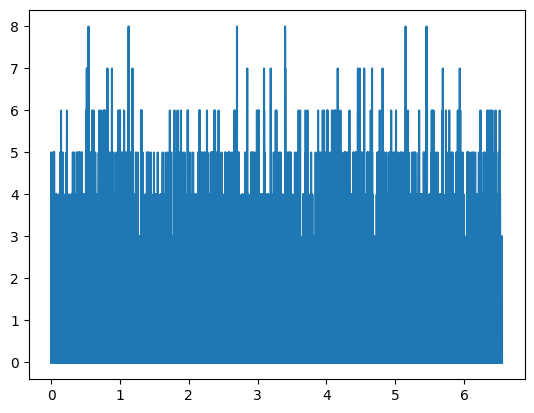

In [11]:
#plot the channel1 trajectory
plt.plot(trajdf['x'],trajdf['ch1'])

In [12]:
#get the intensity mean values
trajdf.mean()

x      3.276800
ch1    0.573471
ch2    0.282196
dtype: float64

In [13]:
#for fun, calculate the PSF and box size
vpsf=((np.pi/2.0)**1.5)*(simsettings['w0']**3)*simsettings['zratio']
vbox=simsettings['boxsize']**3
print('Vpsf',vpsf,'Vbox',vbox,'Vratio',vpsf/vbox)

Vpsf 0.04836114603958391 Vbox 32.76800000000001 Vratio 0.001475865052477536


In [14]:
#now calculate the correlation functions
#bin multilog emulates the binning of an autocorrelator
nchan=len(simspecies)
corrdf=pd.DataFrame()
for i in range(nchan):
    corr=autils.autocorr(trajdf.iloc[:,i+1])
    bcorr,xvals=autils.binmultilog(corr)
    if(i==0):
        corrdf['tau']=xvals*ssimsettings['frametime']*1.0e-6
    corrdf['ch'+str(i+1)]=bcorr

In [15]:
#now calculate the cross-correlation function
ccorr=autils.crosscorr(trajdf['ch1'],trajdf['ch2'])
bccorr,_=autils.binmultilog(ccorr)
corrdf['ccorr']=bccorr

Text(0, 0.5, 'G(tau)')

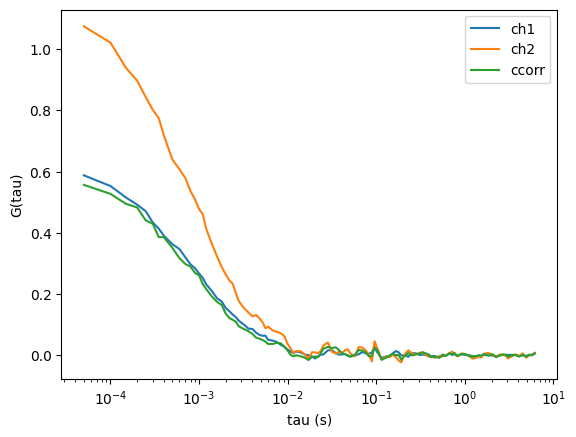

In [16]:
#plot the correlations
plt.plot(corrdf.loc[1:,'tau'],corrdf.loc[1:,'ch1'])
plt.plot(corrdf.loc[1:,'tau'],corrdf.loc[1:,'ch2'])
plt.plot(corrdf.loc[1:,'tau'],corrdf.loc[1:,'ccorr'])
plt.legend(['ch1','ch2','ccorr'])
plt.xscale('log')
plt.xlabel('tau (s)')
plt.ylabel('G(tau)')

In [17]:
#save the table as a zip file (saves a bit of space)
trajdf.to_csv('simulation.csv.zip',compression='zip')

In [18]:
#save the correlations as a csv
corrdf.to_csv('correlations.csv')